In [2]:
import numpy as np
import sys, os 
sys.path.append('../Netket/')
sys.path.append('../ClusterExpansion/')
import netket as nk
import itertools
import matplotlib.pyplot as plt 
import cluster_expansion as ce
# from cluster_expansion import fwht_coeffs_in_cluster_col_order, prepare_fwht_meta_cached, compress_and_reconstruct_cached, _get_topk_indices_jit
import analysis
from analysis import std_phase, ipr, pca_entropy, renyi_entropy, mean_amplitude, uniform_state_overlap, infidelity
import pandas as pd
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor


ERROR:2026-01-22 14:21:36,294:jax._src.xla_bridge:475: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax/_src/xla_bridge.py", line 473, in discover_pjrt_plugins
    plugin_module.initialize()
    ~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 328, in initialize
    _check_cuda_versions(raise_on_first_error=True)
    ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/scratch/ashankar/DataMiningRBMs/.venv/lib/python3.13/site-packages/jax_plugins/xla_cuda12/__init__.py", line 285, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load 

∣NK⟩ Tip: You can disable these tips by setting export NETKET_NO_TIPS=1 in your .bashrc.

In [3]:
import importlib
importlib.reload(analysis)

<module 'analysis' from '/scratch/ashankar/DataMiningRBMs/datamine/../Netket/analysis.py'>

In [4]:
data_root = '..'
data_dirs_set = ['data_optimal_basis_rbm', 'extended_data_optimal_basis_rbm']
datadirs = [f'{data_root}/data/{data_dir_val}' for data_dir_val in data_dirs_set]
h5_files_opt = [f'{data_root}/data/{data_dir_val}/{fp}' for data_dir_val in datadirs for fp in os.listdir(data_dir_val) if fp.endswith('.h5')]

df_opt = analysis.load_outputs_to_dataframe_mult_thread(h5_files_opt, load_eigenstates=False, num_workers=4)
df_opt["idx"] = df_opt["file"].apply(lambda x: int(os.path.basename(x).split('_')[2]))
print(len(df_opt))

700


In [5]:
# hypotheses = {
#     "std_phase" : std_phase,
#     "IPR" : ipr,
#     "SPCA" : pca_entropy,
#     "Renyi_2" : renyi_entropy,
#     "uniform_state_overlap" : uniform_state_overlap,
#     "mean_amplitude" : mean_amplitude,
# }

def sort_normalize(v):
    vs = np.sort(np.abs(v))[::-1]
    # return vs / np.linalg.norm(vs)
    return vs #/ vs[0]

def relative_weights(v, max_N):
    vs = np.sort(np.abs(v))[::-1]
    return np.sum(vs[1:max_N]) /  vs[0]
    # return np.sum(vs[max_N+1:-1]) /  np.sum(vs[0:max_N])

def cluster_expansion_decay(logpsi,hilbert, max_N):
    """
    estimates the decay of cluster expansion coefficients by expanding logpsi = W + \\sum_i c_i \\sigma_i + \\sum_{i<j} c_{ij} \\sigma_i \\sigma_j + .... for the max_N most significant terms
    """
    cluster_coeffs_test_exact = ce.fwht_coeffs_in_cluster_col_order(logpsi, hilbert)
    sorted_c = sort_normalize(cluster_coeffs_test_exact)
    # relweights = relative_weights(sorted_c, max_N)
    gradient, _ = np.polyfit(np.arange(len(sorted_c))[:max_N], np.log(np.abs(sorted_c) + 1e-16)[:max_N], 1)
    decay_const = -gradient

    return decay_const

# Define the CEdecay lambda function
# CEdecay = lambda x: cluster_expansion_decay(np.log(x), nk.hilbert.Spin(1/2, N=16), max_N=16**2+32)
def CEdecay(psi, max_N=16**2+32):
    hilbert = nk.hilbert.Spin(1/2, N=16)
    ce1 = cluster_expansion_decay(np.log(psi), hilbert, max_N=max_N)
    return ce1
    # ce2 = cluster_expansion_decay(psi, hilbert, max_N=16**2+32)
    # return np.min([ce1, ce2])

def CEEntropy(psi):
    hilbert = nk.hilbert.Spin(1/2, N=16)

    cluster_coeffs_test_exact = ce.fwht_coeffs_in_cluster_col_order(np.log(psi), hilbert)
    sorted_c = sort_normalize(cluster_coeffs_test_exact)
    sorted_c = sorted_c / np.sum(sorted_c)
    num_c = len(sorted_c)
    return -1/np.log(num_c) * np.sum(sorted_c * np.log(sorted_c))


def phase_nonrandomness(psi):
    sigma = std_phase(psi)
    return np.abs(sigma - np.pi/np.sqrt(3))

hypotheses_CC = {
    "phase_nonrandomness": phase_nonrandomness,
    "IPR": ipr,
    "SPCA": pca_entropy,
    "uniform_state_overlap": uniform_state_overlap,
    "CEEntropy" : CEEntropy,
    # "uniform_state_overlap2": uniform_state_overlap,

    # "CE": CEdecay,
    # "CE20": partial(CEdecay, max_N=20),
}



# Reload analysis module to ensure fresh state before applying hypotheses
importlib.reload(analysis)

df_mine = analysis.attach_hypotheses_fields_mult_thread(df_opt, hypotheses_CC, num_workers=4)

In [6]:
# features = list(hypotheses_CC.keys())
features = ['CEEntropy', 'SPCA']
# features = ['uniform_state_overlap']
# features = ['uniform_state_overlap', 'std_phase']
traindf = df_mine[features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.1] # 0.1 = 10% relative error 
# traindf = traindf[traindf['uniform_state_overlap'] > 0.05]
# traindf = df_mine[features + ['infidelity']].dropna()
# trindf = traindf[traindf['infidelity'] < 0.9]
print(len(traindf))
X_train, X_test, y_train, y_test = train_test_split(traindf[features], traindf['Delta_E'], test_size=0.2, random_state=42)
print(len(X_train), len(X_test))
model = RandomForestRegressor(n_estimators=1000, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error on training set prediction : ', mean_squared_error(y_train, y_pred_train))
print('Perecentage error in training set prediction :', 100 * np.mean(np.abs(y_train - y_pred_train) / y_train))
print(f"Mean Squared Error: {mse}") 
print("Percentage error in prediction:", 100 * np.mean(np.abs(y_test - y_pred) / y_test))

687
549 138
Mean Squared Error on training set prediction :  3.08030261540985e-05
Perecentage error in training set prediction : 100.01471119348106
Mean Squared Error: 0.000211854490760967
Percentage error in prediction: 242.17253617867902


138


Text(0.001, 0.00015259582422559617, 'Mean Squared Error: 2.12e-04')

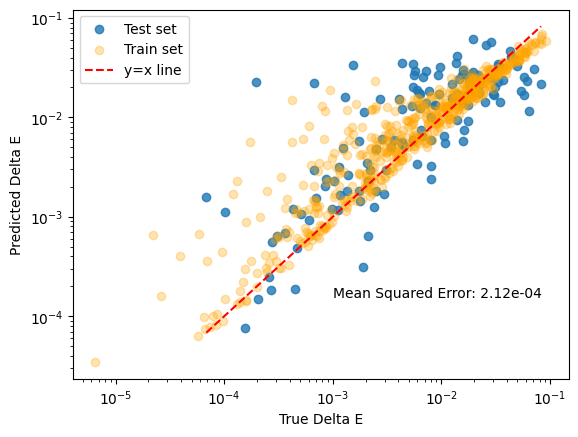

In [7]:
fig, ax = plt.subplots()
print(len(y_test))
ax.scatter(y_test, y_pred, alpha=0.8,label='Test set')
ax.scatter(y_train, y_pred_train, alpha=0.3, color='orange',label='Train set')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x line')
ax.legend()
ax.text(0.001, min(y_pred)*2, f'Mean Squared Error: {mse:.2e}', fontsize=10)
# ax.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')

/tmp/ipykernel_3841381/3127248418.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(features, rotation=45, ha='right')


Text(0, 0.5, 'Mutual Information with Delta E')

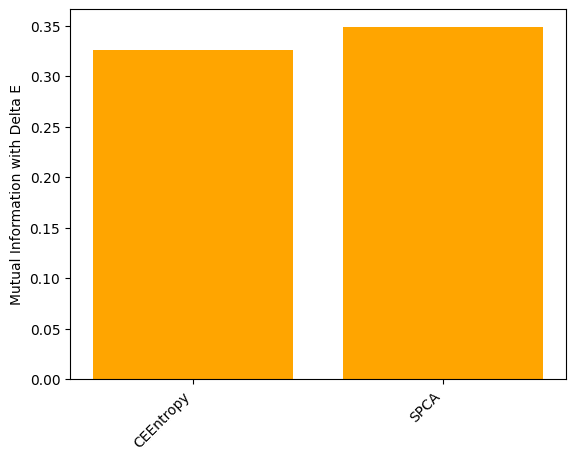

In [8]:
fig, ax = plt.subplots(1)
target_feature = 'Delta_E'

feature_subset = features.copy()
try:
    feature_subset.remove(target_feature)
except ValueError:
    pass    

mutual_information = mutual_info_regression(traindf[feature_subset], traindf[target_feature])
ax.bar(feature_subset, mutual_information, color='orange', alpha=1.0)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.set_ylabel('Mutual Information with Delta E')

<Axes: >

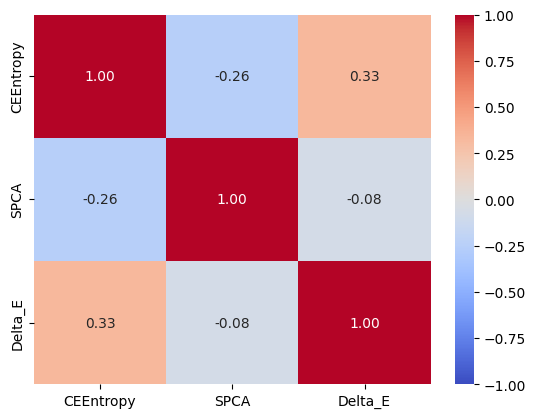

In [9]:
import seaborn as sns
corr = traindf.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
   

In [12]:
features = list(hypotheses_CC.keys())
feature_combinations = []
for r in range(1, len(features)+1):
    feature_combinations.extend(itertools.combinations(features, r))
print(f"Total combinations to evaluate: {len(feature_combinations)}")

mselist = np.ones(len(feature_combinations)) * np.inf
best_model = None


for f_idx, feature_set in enumerate(feature_combinations):
    feature_set = list(feature_set)
    traindf = df_mine[feature_set + ['Delta_E']].dropna()
    traindf = traindf[traindf['Delta_E'] <  0.1]
    model = RandomForestRegressor(n_estimators=1000, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(traindf[feature_set], traindf['Delta_E'], test_size=0.2, random_state=42)
    model.fit(X_train[feature_set], y_train)
    y_pred = model.predict(X_test[feature_set])
    mse = mean_squared_error(y_test, y_pred)
    if best_model is None or mse < np.min(mselist):
        best_model = model
    mselist[f_idx] = mse
    print(f"Features: {feature_set}, Mean Squared Error: {mse}")


best_feature_idx = np.argmin(mselist)
best_features = feature_combinations[best_feature_idx]
best_mse = mselist[best_feature_idx]
print(f"Best feature set: {best_features} with Mean Squared Error: {best_mse}")



Total combinations to evaluate: 31
Features: ['phase_nonrandomness'], Mean Squared Error: 0.0002775095541572492
Features: ['IPR'], Mean Squared Error: 0.0002658650587656383
Features: ['SPCA'], Mean Squared Error: 0.00022518610463633215
Features: ['uniform_state_overlap'], Mean Squared Error: 0.0002523518290983875
Features: ['CEEntropy'], Mean Squared Error: 0.00030228511028667916
Features: ['phase_nonrandomness', 'IPR'], Mean Squared Error: 0.00019157509456309686
Features: ['phase_nonrandomness', 'SPCA'], Mean Squared Error: 0.00017357350665294575
Features: ['phase_nonrandomness', 'uniform_state_overlap'], Mean Squared Error: 0.00020856663087942984
Features: ['phase_nonrandomness', 'CEEntropy'], Mean Squared Error: 0.00018550632320582823
Features: ['IPR', 'SPCA'], Mean Squared Error: 0.00020710227360284274
Features: ['IPR', 'uniform_state_overlap'], Mean Squared Error: 0.0002622297162705716
Features: ['IPR', 'CEEntropy'], Mean Squared Error: 0.00018862652490641776
Features: ['SPCA', 'u

549 138


Text(0.5, 1.0, "Best Feature Set: ['phase_nonrandomness', 'uniform_state_overlap', 'CEEntropy']")

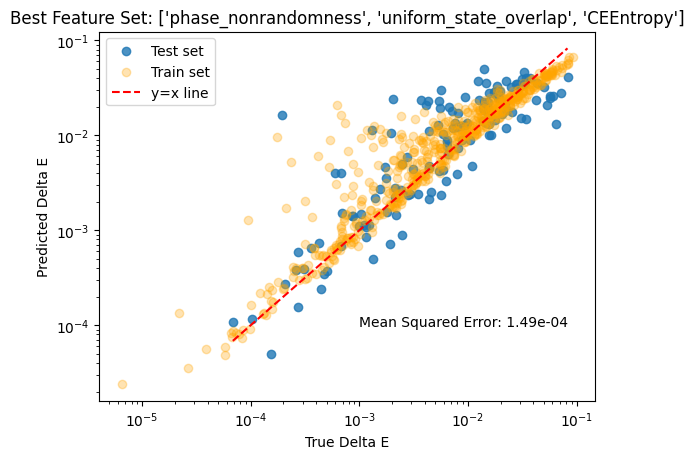

In [24]:
fig, ax = plt.subplots()
best_features = list(best_features)
traindf = df_mine[best_features + ['Delta_E']].dropna()
traindf = traindf[traindf['Delta_E'] <  0.1]
X_train, X_test, y_train, y_test = train_test_split(traindf[best_features], traindf['Delta_E'], test_size=0.2, random_state=42)
y_pred = best_model.predict(X_test[best_features])
y_pred_train = best_model.predict(X_train[best_features])
print(len(y_train), len(y_test))
mse = mean_squared_error(y_test, y_pred)
ax.scatter(y_test, y_pred, alpha=0.8,label='Test set')
ax.scatter(y_train, y_pred_train, alpha=0.3, color='orange',label='Train set')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('True Delta E')   
ax.set_ylabel('Predicted Delta E')
ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='y=x line')
ax.legend()
ax.text(0.001, min(y_pred)*2, f'Mean Squared Error: {mse:.2e}', fontsize=10)
ax.set_title(f'Best Feature Set: {best_features}')
# ax.scatter(y_test, y_pred_xgb, alpha=0.5, color='green')

In [23]:
psi0test = df_mine[df_mine['idx'] == 42]['psi_0'].values[0]
hilbert = nk.hilbert.Spin(1/2, N=16)
cluster_coeffs_test_exact_test_ = ce.fwht_coeffs_in_cluster_col_order(np.log(psi0test), hilbert)
cluster_coeffs_test_exact_test_

array([-5.57732245e+00+9.73121541e-01j, -6.35877535e-04-3.88559502e-04j,
       -6.35877535e-04-3.88559502e-04j, ...,
        2.49730384e-07-2.84008888e-07j,  2.49730384e-07-2.84008888e-07j,
       -1.02985980e-06+1.27128150e-06j], shape=(65536,))